# State Task Networks

This notebook implements in Pyomo the state task network described in Section 3 of Kondili, Pantelides & Sargent (1993).

Kantor has written a state task network package that uses pyomo - see https://jckantor.github.io/STN-Scheduler/. It defines a class called `STN` with methods to make it easier to build the sets for a state task network programmatically. However, different structural models are likely to require different methods. In `mola` the `Specification` class has a single method called `populate` that can be called from a GUI. It uses a JSON file that populates the sets and parameters of an abstract pyomo model. 

The `STN-Scheduler` package does not use the built-in network module in `pyomo` which is a fairly recent development.

In [1]:
from pyomo.environ import *
import itertools

In [2]:
model = ConcreteModel()

# Notation

The time discretisation is defined by

In [3]:
model.H = 10
model.T = Set(initialize=RangeSet(0, model.H), doc='Time Periods')
model.T.pprint()

T : Time Periods
    Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :   11 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


States, tasks and units are defined by

In [4]:
model.States = Set(
    initialize=['Feed A', 'Feed B', 'Feed C', 'Hot A', 'Int BC', 'Int AB',
                'Impure E', 'Product 1', 'Product 2'], doc='States')
model.I = Set(initialize=['Heating', 'Reaction 1', 'Reaction 2', 'Reaction 3', 'Separation'], doc='Tasks')
model.J = Set(initialize=['Heater', 'Reactor 1', 'Reactor 2', 'Still'], doc='Units')

## Task definition

Task $i$ is defined by indexed sets, but we cannot initialize parameters or variables by indexed sets in Pyomo so we use an indexed set and tuples. We could just use the map directly, but it may be easier to specify the index set for the GUI. The user defines the index set and then `mola` builds the tuples.

In [5]:
map_S_I = {
    'Heating': ['Feed A'],
    'Reaction 1': ['Feed B', 'Feed C'],
    'Reaction 2': ['Hot A', 'Int BC'],
    'Reaction 3': ['Int AB', 'Feed C'],
    'Separation': ['Impure E']
}
model.SI = Set(model.I, initialize=map_S_I, within=model.States)
model.S_I = Set(within=model.States * model.I, initialize=[(s, i) for i in model.I for s in model.SI[i]], 
                doc='States that feed task i')
model.S_I.pprint()

S_I : States that feed task i
    Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain     : Size : Members
    None :     2 : S_I_domain :    8 : {('Feed A', 'Heating'), ('Feed B', 'Reaction 1'), ('Feed C', 'Reaction 1'), ('Hot A', 'Reaction 2'), ('Int BC', 'Reaction 2'), ('Int AB', 'Reaction 3'), ('Feed C', 'Reaction 3'), ('Impure E', 'Separation')}


In [6]:
map_S_bar_I = {
    'Heating': ['Hot A'],
    'Reaction 1': ['Int BC'],
    'Reaction 2': ['Product 1', 'Int AB'],
    'Reaction 3': ['Impure E'],
    'Separation': ['Product 2', 'Int AB']
}
model.S_barI = Set(model.I, initialize=map_S_bar_I, within=model.States)
model.S_bar_I = Set(within=model.States * model.I, initialize=[(s, i) for i in model.I for s in model.S_barI[i]],
                   doc='States produced by task i')
model.S_bar_I.pprint()

S_bar_I : States produced by task i
    Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain         : Size : Members
    None :     2 : S_bar_I_domain :    7 : {('Hot A', 'Heating'), ('Int BC', 'Reaction 1'), ('Product 1', 'Reaction 2'), ('Int AB', 'Reaction 2'), ('Impure E', 'Reaction 3'), ('Product 2', 'Separation'), ('Int AB', 'Separation')}


In [7]:
map_rho = {
    ('Feed A', 'Heating'): 1,
    ('Feed B', 'Reaction 1'): 0.5,
    ('Feed C', 'Reaction 1'): 0.5,
    ('Hot A', 'Reaction 2'): 0.4,
    ('Int BC', 'Reaction 2'): 0.6,
    ('Feed C', 'Reaction 3'): 0.2,
    ('Int AB', 'Reaction 3'): 0.8,
    ('Impure E', 'Separation'): 1
}
model.rho = Param(model.S_I, initialize=map_rho, doc='Proportion of input of task i from state s')
model.rho.pprint()

rho : Proportion of input of task i from state s
    Size=8, Index=S_I, Domain=Any, Default=None, Mutable=False
    Key                        : Value
         ('Feed A', 'Heating') :     1
      ('Feed B', 'Reaction 1') :   0.5
      ('Feed C', 'Reaction 1') :   0.5
      ('Feed C', 'Reaction 3') :   0.2
       ('Hot A', 'Reaction 2') :   0.4
    ('Impure E', 'Separation') :     1
      ('Int AB', 'Reaction 3') :   0.8
      ('Int BC', 'Reaction 2') :   0.6


In [8]:
map_rho_bar = {
    ('Hot A', 'Heating'): 1,
    ('Int BC', 'Reaction 1'): 1,
    ('Product 1', 'Reaction 2'): 0.4,
    ('Int AB', 'Reaction 2'): 0.6,
    ('Impure E', 'Reaction 3'): 1,
    ('Product 2', 'Separation'): 0.9,
    ('Int AB', 'Separation'): 0.1
}
model.rho_bar = Param(model.S_bar_I, initialize=map_rho_bar,
                      doc='Proportion of output of task i to state s')
model.rho_bar.pprint()

rho_bar : Proportion of output of task i to state s
    Size=7, Index=S_bar_I, Domain=Any, Default=None, Mutable=False
    Key                         : Value
           ('Hot A', 'Heating') :     1
     ('Impure E', 'Reaction 3') :     1
       ('Int AB', 'Reaction 2') :   0.6
       ('Int AB', 'Separation') :   0.1
       ('Int BC', 'Reaction 1') :     1
    ('Product 1', 'Reaction 2') :   0.4
    ('Product 2', 'Separation') :   0.9


In [9]:
map_P = {
    ('Hot A', 'Heating'): 1,
    ('Int BC', 'Reaction 1'): 2,
    ('Product 1', 'Reaction 2'): 2,
    ('Int AB', 'Reaction 2'): 2,
    ('Impure E', 'Reaction 3'): 1,
    ('Product 2', 'Separation'): 1,
    ('Int AB', 'Separation'): 2
}
model.P = Param(model.S_bar_I, initialize=map_P, 
                doc='Processing time for the output of task i to state s')
model.P.pprint()

P : Processing time for the output of task i to state s
    Size=7, Index=S_bar_I, Domain=Any, Default=None, Mutable=False
    Key                         : Value
           ('Hot A', 'Heating') :     1
     ('Impure E', 'Reaction 3') :     1
       ('Int AB', 'Reaction 2') :     2
       ('Int AB', 'Separation') :     2
       ('Int BC', 'Reaction 1') :     2
    ('Product 1', 'Reaction 2') :     2
    ('Product 2', 'Separation') :     1


In [10]:
def p_rule(model, i):
    return max(model.P[s, i] for s in model.S_barI[i])
model.p = Param(model.I, initialize=p_rule, doc='Completion time for task i')
model.p.pprint()

p : Completion time for task i
    Size=5, Index=I, Domain=Any, Default=None, Mutable=False
    Key        : Value
       Heating :     1
    Reaction 1 :     2
    Reaction 2 :     2
    Reaction 3 :     1
    Separation :     2


In [11]:
map_K_I = {
    'Heating': ['Heater'],
    'Reaction 1': ['Reactor 1', 'Reactor 2'],
    'Reaction 2': ['Reactor 1', 'Reactor 2'],
    'Reaction 3': ['Reactor 1', 'Reactor 2'],
    'Separation': ['Still']
}
model.KI = Set(model.I, initialize=map_K_I, within=model.J)
model.K_I = Set(within=model.J * model.I, initialize=[(j, i) for i in model.I for j in model.KI[i]], 
                doc='Units capable of performing task i')
model.K_I.pprint()

K_I : Units capable of performing task i
    Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain     : Size : Members
    None :     2 : K_I_domain :    8 : {('Heater', 'Heating'), ('Reactor 1', 'Reaction 1'), ('Reactor 2', 'Reaction 1'), ('Reactor 1', 'Reaction 2'), ('Reactor 2', 'Reaction 2'), ('Reactor 1', 'Reaction 3'), ('Reactor 2', 'Reaction 3'), ('Still', 'Separation')}


## State definition

The set $T_s$ is the set of tasks that receive material from state $s$. It is the inversion of the set $S_i$.

In [12]:
map_T_S = {}
for s, i in model.S_I:
    map_T_S.setdefault(s, []).append(i)

map_T_S

{'Feed A': ['Heating'],
 'Feed B': ['Reaction 1'],
 'Feed C': ['Reaction 1', 'Reaction 3'],
 'Hot A': ['Reaction 2'],
 'Int BC': ['Reaction 2'],
 'Int AB': ['Reaction 3'],
 'Impure E': ['Separation']}

The `setdefault` method for a dict ensures that we append to an empty list if the state does not yet exist in `map_T_S`. 

In [13]:
model.TS = Set(model.States, initialize=map_T_S, within=model.I)
model.T_S = Set(within=model.I * model.States, 
                initialize=[(i, s) for s in model.TS.keys() for i in model.TS[s]], 
                doc='Tasks receiving material from state s')
model.T_S.pprint()

T_S : Tasks receiving material from state s
    Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain     : Size : Members
    None :     2 : T_S_domain :    8 : {('Heating', 'Feed A'), ('Reaction 1', 'Feed B'), ('Reaction 1', 'Feed C'), ('Reaction 3', 'Feed C'), ('Reaction 2', 'Hot A'), ('Reaction 2', 'Int BC'), ('Reaction 3', 'Int AB'), ('Separation', 'Impure E')}


The set $\bar{T}_s$ is the set of tasks that produce material in state $s$.

In [14]:
map_T_bar_S = {}
for s, i in model.S_bar_I:
    map_T_bar_S.setdefault(s, []).append(i)

map_T_bar_S

{'Hot A': ['Heating'],
 'Int BC': ['Reaction 1'],
 'Product 1': ['Reaction 2'],
 'Int AB': ['Reaction 2', 'Separation'],
 'Impure E': ['Reaction 3'],
 'Product 2': ['Separation']}

In [15]:
model.T_barS = Set(model.States, initialize=map_T_bar_S, within=model.I)
model.T_bar_S = Set(within=model.I * model.States, 
                    initialize=[(i, s) for s in model.T_barS for i in model.T_barS[s]],
                    doc='Tasks producing material in state s')
model.T_bar_S.pprint()

T_bar_S : Tasks producing material in state s
    Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain         : Size : Members
    None :     2 : T_bar_S_domain :    7 : {('Heating', 'Hot A'), ('Reaction 1', 'Int BC'), ('Reaction 2', 'Int AB'), ('Separation', 'Int AB'), ('Reaction 3', 'Impure E'), ('Reaction 2', 'Product 1'), ('Separation', 'Product 2')}


In [16]:
map_C = {
    'Feed A': float('inf'), 'Feed B': float('inf'), 'Feed C': float('inf'),
    'Hot A': 100, 'Int BC': 150, 'Int AB': 200, 'Impure E': 100,
    'Product 1': float('inf'), 'Product 2': float('inf')}
model.C = Param(model.States, initialize=map_C, doc='Maximum storage capacity dedicated to state s')
model.C.pprint()

C : Maximum storage capacity dedicated to state s
    Size=9, Index=States, Domain=Any, Default=None, Mutable=False
    Key       : Value
       Feed A :   inf
       Feed B :   inf
       Feed C :   inf
        Hot A :   100
     Impure E :   100
       Int AB :   200
       Int BC :   150
    Product 1 :   inf
    Product 2 :   inf


## Unit definition

The set $I_j$ is the set of tasks that can be performed by unit $j$. It is the inversion of the set $K_i$.

In [17]:
map_I_J = {}
for j, i in model.K_I:
    map_I_J.setdefault(j, []).append(i)

In [18]:
model.IJ = Set(model.J, initialize=map_I_J, within=model.I)
model.I_J = Set(within=model.I * model.J, initialize=[(i, j) for j in model.J for i in model.IJ[j]],
                doc='Tasks that can be performed by unit j')
model.I_J.pprint()

I_J : Tasks that can be performed by unit j
    Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain     : Size : Members
    None :     2 : I_J_domain :    8 : {('Heating', 'Heater'), ('Reaction 1', 'Reactor 1'), ('Reaction 2', 'Reactor 1'), ('Reaction 3', 'Reactor 1'), ('Reaction 1', 'Reactor 2'), ('Reaction 2', 'Reactor 2'), ('Reaction 3', 'Reactor 2'), ('Separation', 'Still')}


In [19]:
model.I_J.pprint()

I_J : Tasks that can be performed by unit j
    Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain     : Size : Members
    None :     2 : I_J_domain :    8 : {('Heating', 'Heater'), ('Reaction 1', 'Reactor 1'), ('Reaction 2', 'Reactor 1'), ('Reaction 3', 'Reactor 1'), ('Reaction 1', 'Reactor 2'), ('Reaction 2', 'Reactor 2'), ('Reaction 3', 'Reactor 2'), ('Separation', 'Still')}


In [20]:
map_V_max = {
    ('Heating', 'Heater'): 100,
    ('Reaction 1', 'Reactor 1'): 80,
    ('Reaction 2', 'Reactor 1'): 80,
    ('Reaction 3', 'Reactor 1'): 80,
    ('Reaction 1', 'Reactor 2'): 50,
    ('Reaction 2', 'Reactor 2'): 50,
    ('Reaction 3', 'Reactor 2'): 50,
    ('Separation', 'Still'): 200
}
map_V_min = {
    ('Heating', 'Heater'): 0,
    ('Reaction 1', 'Reactor 1'): 0,
    ('Reaction 2', 'Reactor 1'): 0,
    ('Reaction 3', 'Reactor 1'): 0,
    ('Reaction 1', 'Reactor 2'): 0,
    ('Reaction 2', 'Reactor 2'): 0,
    ('Reaction 3', 'Reactor 2'): 0,
    ('Separation', 'Still'): 0
}
model.V_max = Param(model.I_J, initialize=map_V_max, 
                    doc='Maximum capacity of unit j when used for performing task i')
model.V_min = Param(model.I_J, initialize=map_V_min, 
                    doc='Minimum capacity of unit j when used for performing task i')

# Variables

In [21]:
model.W = Var(model.I_J, model.T, doc='Start task k using unit j at time t', within=Binary)

In [22]:
model.B = Var(model.I_J, model.T,
              doc='Amount of material which starts undergoing task i in unit j at beginning of t', within=NonNegativeReals)

In [23]:
model.S = Var(model.States, model.T, 
              doc='Amount of material stored in state s at beginning of t', within=NonNegativeReals)

In [24]:
model.Q = Var(model.J, model.T, doc='Amount of material in unit j at the beginning of time t', within=NonNegativeReals)

# Constraints

## Allocation Constraints

In [25]:
model.M = Param(initialize=40, doc='Allocation constraint parameter')
def allocation_constraints_rule(model, i, j, t):
    lhs = sum(model.W[idash, j, tdash] for tdash in model.T for idash in model.IJ[j] 
              if tdash >= t and tdash <= t + model.p[i] - 1) - 1
    rhs = model.M * (1 - model.W[i, j, t])
    return lhs <= rhs
model.allocation_constraints = Constraint(model.I_J, model.T, rule=allocation_constraints_rule)

In [26]:
model.allocation_constraints['Separation', 'Still', 0].pprint()

{Member of allocation_constraints} : Size=88, Index=allocation_constraints_index, Active=True
    Key                        : Lower : Body                                                                               : Upper : Active
    ('Separation', 'Still', 0) :  -Inf : W[Separation,Still,0] + W[Separation,Still,1] - 1 - 40*(1 - W[Separation,Still,0]) :   0.0 :   True


Note that we use the indexed set `model.IJ` to sum over tasks for fixed unit $j$.

## Capacity Limitations

Why can't we use the `inequality` function here? It leads to an uninitialied NumericValue error when running the optimisation. The function is not well documented. It might be that it can only be used with a parameter in the lower or upper argument and the error is only shown at optimisation.

I have used two inequality constraints instead.

In [27]:
# def capacity_limitations_rule1(model, j, i, t):
#     return inequality(model.W[i, j, t] * model.V_min[i, j], model.B[i, j, t], model.W[i, j, t] * model.V_max[i, j]) 
# model.capacity_limitations1 = Constraint(model.K_I, model.T, rule=capacity_limitations_rule1)
def capacity_limitations_rule1a(model, j, i, t):
    return model.W[i, j, t] * model.V_min[i, j] <= model.B[i, j, t]
model.capacity_limitations1a = Constraint(model.K_I, model.T, rule=capacity_limitations_rule1a)
def capacity_limitations_rule1b(model, j, i, t):
    return model.B[i, j, t] <= model.W[i, j, t] * model.V_max[i, j]
model.capacity_limitations1b = Constraint(model.K_I, model.T, rule=capacity_limitations_rule1b)

We can use `inequality` here because `model.C` is a parameter.

In [28]:
def capacity_limitations_rule2(model, s, t):
    return inequality(0, model.S[s, t], model.C[s]) 
model.capacity_limitations2 = Constraint(model.States, model.T, rule=capacity_limitations_rule2)
# def capacity_limitations_rule2a(model, s, t):
#     return 0 <= model.S[s, t] 
# model.capacity_limitations2a = Constraint(model.States, model.T, rule=capacity_limitations_rule2a)
# def capacity_limitations_rule2b(model, s, t):
#     return model.S[s, t] <= model.C[s] 
# model.capacity_limitations2b = Constraint(model.States, model.T, rule=capacity_limitations_rule2b)

## Unit Mass Balances

This is an additional constraint added by Kantor in his implementation.

In [29]:
def unit_balances_rule(model, j, t):
    if t == model.T.first():
        rhs = 0
    else:
        rhs = model.Q[j, t - 1]
    rhs += sum(model.B[i, j, t] for i in model.IJ[j])
    for i in model.IJ[j]:
        for s in model.S_barI[i]:
            if t >= model.P[s, i]:
                rhs -= model.rho_bar[s, i] * model.B[i, j, t-model.P[s, i]] 
    return model.Q[j, t] == rhs
model.unit_balances = Constraint(model.J, model.T, rule=unit_balances_rule)

In [30]:
def terminal_unit_rule(model, j):
    return model.Q[j, model.H] == 0
    
model.terminal_unit = Constraint(model.J, rule=terminal_unit_rule)

## Material Balances

In [31]:
model.D = Param(model.States, model.T, initialize=0,
                   doc='Delivery of material in state s at time t')
model.R = Param(model.States, model.T, initialize=0,
                   doc='Receipt of material in state s at time t')

We fix the initial states using an equality constraint in the material balance equation.

In [32]:
import numpy as np
init_S = {
    'Feed A': 200, 'Feed B': 200, 'Feed C': 200,
     'Hot A': 0, 'Int BC': 0, 'Int AB': 0, 'Impure E': 0,
     'Product 1': 0, 'Product 2': 0
}

In [33]:
def material_balances_rule(model, s, t):
    if t == model.T.first():
        rhs = init_S[s]
    else:
        rhs = model.S[s, t-1]
    if s in model.T_barS.keys():
        for i in model.T_barS[s]:
            rhs += model.rho_bar[s, i] * sum(model.B[i, j, t-model.P[s, i]] 
                   for j in model.KI[i] if t >= model.P[s, i])
    if s in model.TS.keys():
        for i in model.TS[s]:
            rhs -= model.rho[s, i] * sum(model.B[i, j, t] for j in model.KI[i])    
    return model.S[s, t] == rhs + model.R[s, t] - model.D[s, t]
model.material_balances = Constraint(model.States, model.T, rule=material_balances_rule)

## Product deliveries and raw material receipts during the horizon

This modification is incorporated in the previous section.

## Temporary Unavailability of Equipment

We don't need this constraint for the example.

## Limited Availability of Utilities and Man-Power

We don't need this constraint for the example.

## Cleaning Equipment Items

We don't need this constraint for the example.

    def construct_konidili_solution_enforce(self):
        """ The nominal model with the data of Kondili's paper has several optimizers. The following
        constraints force the exact same solution as in the paper (the objective is unaffected)
        :return: list of cvx.Constraint
        """
        constraint_kondili = []
        constraint_kondili.append( [self.y_ijt[0,0,1] == 52] )
        constraint_kondili.append( [self.y_ijt[1,1,0] == 80] )
        return constraint_kondili

# Objective Function

The objective for the paper is the maximisation of profit.

In [34]:
model.States.pprint()

States : States
    Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :    9 : {'Feed A', 'Feed B', 'Feed C', 'Hot A', 'Int BC', 'Int AB', 'Impure E', 'Product 1', 'Product 2'}


In [35]:
def cost_rule(model, s, t):
    if s in ['Feed A', 'Feed B', 'Feed C']:
        cost = 0
    elif s in ['Hot A', 'Int BC', 'Int AB', 'Impure E']:
        cost = -1
    elif s in ['Product 1', 'Product 2']:
        cost = 10
    return cost
model.Cost = Param(model.States, model.T, initialize=cost_rule,
                   doc='Unit price of material in state s at time t')

In [36]:
def profit_rule(model):
    value_products = sum(model.Cost[s, model.H] * model.S[s, model.H] +
              sum(model.Cost[s, t] * model.D[s, t] for t in model.T if t < model.H) for s in model.States)
    return value_products
model.obj = Objective(rule=profit_rule, doc='Maximisation of Profit', sense=maximize)
model.obj.pprint()

obj : Maximisation of Profit
    Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : maximize : - S[Hot A,10] - S[Int BC,10] - S[Int AB,10] - S[Impure E,10] + 10*S[Product 1,10] + 10*S[Product 2,10]


# Solution

In [37]:
opt = SolverFactory("glpk")
results = opt.solve(model)
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2744.375
  Upper bound: 2744.375
  Number of objectives: 1
  Number of constraints: 555
  Number of variables: 320
  Number of nonzeros: 1465
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 12497
      Number of created subproblems: 12497
  Error rc: 0
  Time: 11.993349552154541
# ----------------------------------------------------------
#   Solution Information
# -----------------

In [38]:
import plotnine as pn
import mola.output as mo
import pandas as pd
import numpy as np

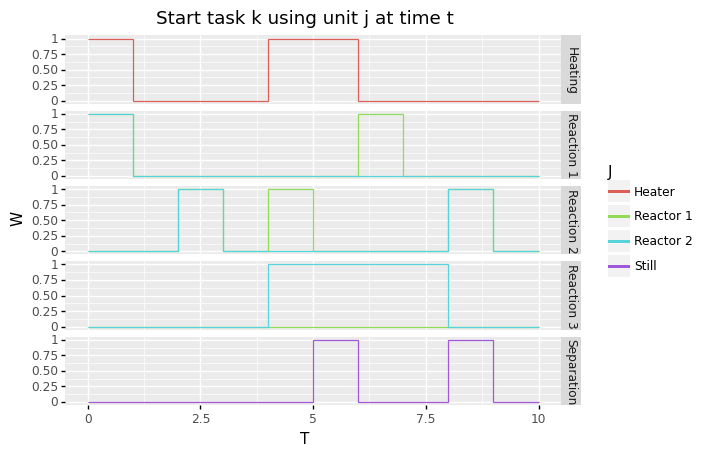

<ggplot: (8778252803957)>

In [39]:
W_df = mo.get_entity(model.W)
(pn.ggplot(W_df, pn.aes('T', 'W')) + pn.ggtitle(model.W.doc) +
 pn.geom_step(pn.aes(color='J'), direction='hv') +
 pn.facet_grid('I~'))

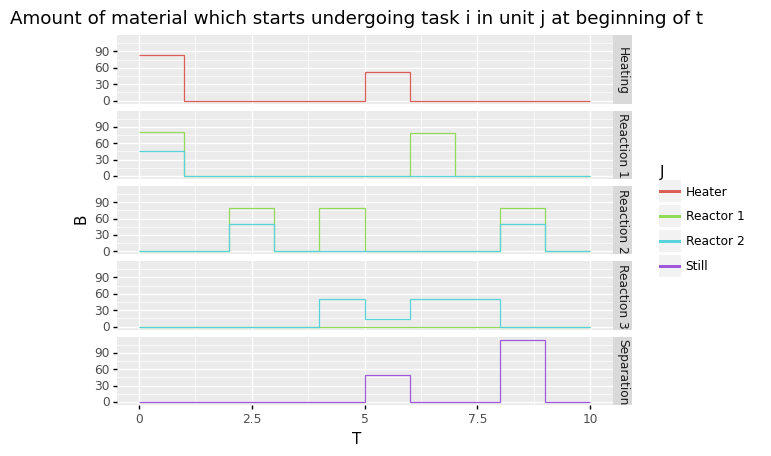

<ggplot: (8778244848689)>

In [40]:
B_df = mo.get_entity(model.B)
(pn.ggplot(B_df, pn.aes('T', 'B')) + pn.ggtitle(model.B.doc) +
 pn.geom_step(pn.aes(color='J'), direction='hv') +
 pn.facet_grid('I~'))

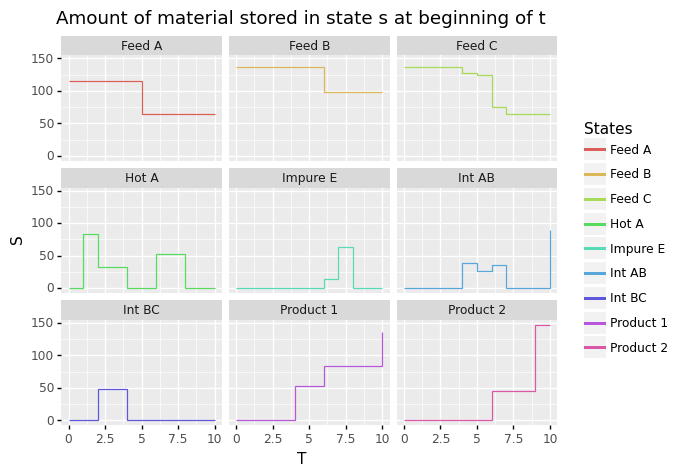

<ggplot: (8778244689889)>

In [41]:
S_df = mo.get_entity(model.S)
(pn.ggplot(S_df, pn.aes('T', 'S')) + pn.ggtitle(model.S.doc) +
 pn.geom_step(pn.aes(color='States'), direction='hv') +
 pn.facet_wrap('States'))

In [42]:
value(model.obj)

2744.375

This is value of the objective in Kondelili et al. (1993). The amount of products produced at the end of the time horizon are also the same.

In [61]:
print(value(model.S['Product 1', 10]), value(model.S['Product 2', 10]))

136.0 147.375


# Abstract State Task Model

In [43]:
import pyomo.network as pn
pa_model = ConcreteModel()

In [44]:
from mola.specification5 import Specification
import pyomo.environ as pe
class KondiliExampleSpecification(Specification):
    """
    A Mola Specification class containing an abstract model to solve the simplest example problem
    described in Kondili, Pantelides & Sargent (1993).
    """
    name = "Kondili et al. Specification"
    user_defined_sets = {
        'States': {'doc': 'States'},
        'I': {'doc': 'Tasks'},
        'J': {'doc': 'Units'},
    }
    user_defined_indexed_sets = {
        'SI': {'index': ['I'], 'doc': 'States that feed task i', 'within': ['States']},
        'S_barI': {'index': ['I'], 'doc': 'States produced by task i', 'within': ['States']},
        'KI': {'index': ['I'], 'doc': 'Units capable of performing task i', 'within': ['J']},
        'TS': {'index': ['States'], 'doc': 'Tasks receiving material from state s', 'within': ['I']},
    }
    user_defined_parameters = {
        'H': {'doc': 'Time horizon'},
        'C': {'index': ['States'], 'doc': 'Maximum storage capacity dedicated to state s'},
        'M': {'doc': 'Allocation constraint parameter'},
        'P': {'index': ['States', 'I'], 'doc': 'Processing time for the output of task i to state s'},
#        'rho': {'index': ['S_I'], 'doc': 'Proportion of input of task i from state s'},
        'rho_bar': {'index': ['States', 'I'], 'doc': 'Proportion of output of task i to state s'},
    }
    # db parameters need to be constructed explicitly
    controllers = {"Standard": "StandardController"}
    default_settings = {
    }

    def __init__(self):

        # setup abstract model
        abstract_model = self.abstract_model = pe.AbstractModel()

        # user-defined sets
        for s, d in self.user_defined_sets.items():
            abstract_model.add_component(s, pe.Set(doc=d['doc']))
            
        # user-defined indexed sets
        for s, val in self.user_defined_indexed_sets.items():
            idx = [abstract_model.component(i) for i in val['index']]
            abstract_model.add_component(s, pe.Set(*idx, doc=val['doc'], 
                                                   within=abstract_model.component(val['within'][0])))
            
        # built in model sets
        abstract_model.T = Set(doc='Time Periods')
        abstract_model.T_S = Set(within=abstract_model.I * abstract_model.States, 
                                 doc='Tasks receiving material from state s')
        abstract_model.T_barS = Set(within=abstract_model.I * abstract_model.States, 
                                    doc='Tasks receiving material from state s')
        abstract_model.IJ = Set(model.J, within=abstract_model.I)
        abstract_model.I_J = Set(within=abstract_model.I * abstract_model.J, 
                                 doc='Tasks that can be performed by unit j')
        abstract_model.K_I = Set(within=abstract_model.J * abstract_model.I, 
                                 doc='Units capable of performing task i')
        abstract_model.S_I = Set(within=abstract_model.States * abstract_model.I,
                                 doc='States that feed task i')
        abstract_model.S_bar_I = Set(within=abstract_model.States * abstract_model.I,
                                 doc='States produced by task i')

        # user-defined parameters
        for param, val in self.user_defined_parameters.items():
            print(param)
            if 'index' in val:
                idx = [abstract_model.component(i) for i in val['index']]
                abstract_model.add_component(param, pe.Param(*idx, doc=val['doc'], within=pe.Reals))
            else:
                abstract_model.add_component(param, pe.Param(doc=val['doc'], within=pe.Reals))
                
        def p_rule(model, i):
            return max(model.P[s, i] for s in model.S_barI[i])
        abstract_model.p = Param(abstract_model.I, initialize=p_rule, doc='Completion time for task i')

        
        # variables
        abstract_model.W = Var(abstract_model.I_J, abstract_model.T, 
                               doc='Start task k using unit j at time t', within=Binary)

        abstract_model.B = Var(abstract_model.I_J, abstract_model.T, 
                               doc='Amount of material which starts undergoing task i in unit j at beginning of t',
                               within=NonNegativeReals)

        abstract_model.S = Var(abstract_model.States, abstract_model.T, 
                               doc='Amount of material stored in state s at beginning of t', 
                               within=NonNegativeReals)

        abstract_model.Q = Var(abstract_model.J, abstract_model.T, 
                               doc='Amount of material in unit j at the beginning of time t', 
                               within=NonNegativeReals)

        # objective
        def cost_rule(model, s, t):
            if s in ['Feed A', 'Feed B', 'Feed C']:
                cost = 0.0
            elif s in ['Hot A', 'Int BC', 'Int AB', 'Impure E']:
                cost = -1.0
            elif s in ['Product 1', 'Product 2']:
                cost = 10.0
            return cost
        abstract_model.Cost = Param(abstract_model.States, abstract_model.T, initialize=cost_rule,
                                    doc='Unit price of material in state s at time t')

        abstract_model.D = Param(abstract_model.States, abstract_model.T, default=0,
                                 doc='Delivery of material in state s at time t')
        abstract_model.R = Param(abstract_model.States, abstract_model.T, default=0,
                                  doc='Receipt of material in state s at time t')
        def profit_rule(model):
            value_products = sum(model.Cost[s, model.H] * model.S[s, model.H] +
                             sum(model.Cost[s, t] * model.D[s, t] for t in model.T if t < model.H) 
                             for s in model.States)
            return value_products
        abstract_model.obj = Objective(rule=profit_rule, doc='Maximisation of Profit', sense=maximize)


        # constraints
        
        def allocation_constraints_rule(model, i, j, t):
            lhs = sum(model.W[idash, j, tdash] for tdash in model.T for idash in model.IJ[j] 
                      if tdash >= t and tdash <= t + model.p[i] - 1) - 1
            rhs = model.M * (1 - model.W[i, j, t])
            return lhs <= rhs
        abstract_model.allocation_constraints = Constraint(abstract_model.I_J, abstract_model.T, 
                                                           rule=allocation_constraints_rule)

        def capacity_limitations_rule1a(model, j, i, t):
            return model.W[i, j, t] * model.V_min[i, j] <= model.B[i, j, t]
        abstract_model.capacity_limitations1a = Constraint(abstract_model.K_I, abstract_model.T, 
                                                           rule=capacity_limitations_rule1a)
        def capacity_limitations_rule1b(model, j, i, t):
            return model.B[i, j, t] <= model.W[i, j, t] * model.V_max[i, j]
        abstract_model.capacity_limitations1b = Constraint(abstract_model.K_I, abstract_model.T, 
                                                           rule=capacity_limitations_rule1b)

        def capacity_limitations_rule2(model, s, t):
            return inequality(0, model.S[s, t], model.C[s]) 
        abstract_model.capacity_limitations2 = Constraint(abstract_model.States, abstract_model.T, 
                                                          rule=capacity_limitations_rule2)

        def unit_balances_rule(model, j, t):
            if t == model.T.first():
                rhs = 0
            else:
                rhs = model.Q[j, t - 1]
            rhs += sum(model.B[i, j, t] for i in model.IJ[j])
            for i in model.IJ[j]:
                for s in model.S_barI[i]:
                    if t >= model.P[s, i]:
                        rhs -= model.rho_bar[s, i] * model.B[i, j, t-model.P[s, i]] 
            return model.Q[j, t] == rhs
        abstract_model.unit_balances = Constraint(abstract_model.J, abstract_model.T, rule=unit_balances_rule)

        def terminal_unit_rule(model, j):
            return model.Q[j, model.H] == 0
        abstract_model.terminal_unit = Constraint(abstract_model.J, rule=terminal_unit_rule)

        def material_balances_rule(model, s, t):
            if t == model.T.first():
                rhs = init_S[s]
            else:
                rhs = model.S[s, t-1]
            if s in model.T_barS.keys():
                for i in model.T_barS[s]:
                    rhs += model.rho_bar[s, i] * sum(model.B[i, j, t-model.P[s, i]] 
                           for j in model.KI[i] if t >= model.P[s, i])
            if s in model.TS.keys():
                for i in model.TS[s]:
                    rhs -= model.rho[s, i] * sum(model.B[i, j, t] for j in model.KI[i])    
            return model.S[s, t] == rhs + model.R[s, t] - model.D[s, t]
        abstract_model.material_balances = Constraint(abstract_model.States, model.T, rule=material_balances_rule)


    def populate(self, json_files=None):

        olca_dp = pyod.DataPortal()

        # user data
        for json_file in json_files:
            if json_file:
                olca_dp.load(filename=json_file)
                
        # built-in sets
        map_I_J = {}
        for i, units in olca_dp.data('KI').items():
            for j in units:
                map_I_J.setdefault(j, []).append(i)
        olca_dp.__setitem__('IJ', map_I_J)
        olca_dp.__setitem__('I_J', [(i, j) for j in olca_dp.data('J') for i in map_I_J[j]])
        
        # built-in parameters
        olca_dp.__setitem__('T', range(0, int(olca_dp.data('H'))+1))
        
        # use DataPortal to build concrete instance
        model_instance = self.abstract_model.create_instance(olca_dp)

        return model_instance

    def get_default_sets(self, d=None):
        user_sets = {
            'States': [],
            'I': [],
            'J': [],
        }
        if d is not None:
            user_sets.update(d)

        return user_sets

    def get_default_indexed_sets(self, user_sets, d=None):
        user_indexed_sets = {
            'SI': [{'index': [i], 'members': []} for i in user_sets['I']],
            'S_barI': [{'index': [i], 'members': []} for i in user_sets['I']],
            'KI': [{'index': [i], 'members': []} for i in user_sets['I']],
            'TS': [{'index': [s], 'members': []} for s in user_sets['States']],
        }
        if d is not None:
            user_indexed_sets.update(d)

        return user_indexed_sets
    
    def get_default_parameters(self, user_sets):
#         map_I_J = {}
#         for i, units in indexed_user_sets['KI'].items():
#             for j in units:
#                 map_I_J.setdefault(j, []).append(i)
        user_params = {
            'C': [{'index': [s], 'value': 0} for s in user_sets['States']],
            'H': 10.0,
            'M': 40.0,
            'P': [{'index': [sb, i], 'value': 0} for i in user_sets['I'] for sb in user_sets['S_barI'][i]],
            'rho_bar': [{'index': [sb, i], 'value': 0} for i in user_sets['I'] for sb in user_sets['S_barI'][i]],
        }

        return user_params


In [45]:
spec = KondiliExampleSpecification()

H
C
M
P
rho_bar


In [46]:
import json
sets = {'I': list(model.I), 'J': list(model.J), 'States':list(model.States)}
sets_json_file = 'Configuration/Kondili_sets.json'
with open(sets_json_file, 'w') as fp:
    json.dump(sets, fp, indent=4)
sets

{'I': ['Heating', 'Reaction 1', 'Reaction 2', 'Reaction 3', 'Separation'],
 'J': ['Heater', 'Reactor 1', 'Reactor 2', 'Still'],
 'States': ['Feed A',
  'Feed B',
  'Feed C',
  'Hot A',
  'Int BC',
  'Int AB',
  'Impure E',
  'Product 1',
  'Product 2']}

In [47]:
indexed_sets = {'KI': map_K_I, 'S_barI': map_S_bar_I}
indexed_sets_json_file = 'Configuration/Kondili_indexed_sets.json'
with open(indexed_sets_json_file, 'w') as fp:
    json.dump(indexed_sets, fp, indent=4)
sets.update(indexed_sets)
sets

{'I': ['Heating', 'Reaction 1', 'Reaction 2', 'Reaction 3', 'Separation'],
 'J': ['Heater', 'Reactor 1', 'Reactor 2', 'Still'],
 'States': ['Feed A',
  'Feed B',
  'Feed C',
  'Hot A',
  'Int BC',
  'Int AB',
  'Impure E',
  'Product 1',
  'Product 2'],
 'KI': {'Heating': ['Heater'],
  'Reaction 1': ['Reactor 1', 'Reactor 2'],
  'Reaction 2': ['Reactor 1', 'Reactor 2'],
  'Reaction 3': ['Reactor 1', 'Reactor 2'],
  'Separation': ['Still']},
 'S_barI': {'Heating': ['Hot A'],
  'Reaction 1': ['Int BC'],
  'Reaction 2': ['Product 1', 'Int AB'],
  'Reaction 3': ['Impure E'],
  'Separation': ['Product 2', 'Int AB']}}

In [48]:
model.P['Hot A', 'Heating']
model.rho_bar.pprint()

rho_bar : Proportion of output of task i to state s
    Size=7, Index=S_bar_I, Domain=Any, Default=None, Mutable=False
    Key                         : Value
           ('Hot A', 'Heating') :     1
     ('Impure E', 'Reaction 3') :     1
       ('Int AB', 'Reaction 2') :   0.6
       ('Int AB', 'Separation') :   0.1
       ('Int BC', 'Reaction 1') :     1
    ('Product 1', 'Reaction 2') :   0.4
    ('Product 2', 'Separation') :   0.9


In [49]:
p = spec.get_default_parameters(sets)
for item in p['P']:
    item['value'] = model.P[item['index'][0], item['index'][1]]
p

{'C': [{'index': ['Feed A'], 'value': 0},
  {'index': ['Feed B'], 'value': 0},
  {'index': ['Feed C'], 'value': 0},
  {'index': ['Hot A'], 'value': 0},
  {'index': ['Int BC'], 'value': 0},
  {'index': ['Int AB'], 'value': 0},
  {'index': ['Impure E'], 'value': 0},
  {'index': ['Product 1'], 'value': 0},
  {'index': ['Product 2'], 'value': 0}],
 'H': 10.0,
 'M': 40.0,
 'P': [{'index': ['Hot A', 'Heating'], 'value': 1},
  {'index': ['Int BC', 'Reaction 1'], 'value': 2},
  {'index': ['Product 1', 'Reaction 2'], 'value': 2},
  {'index': ['Int AB', 'Reaction 2'], 'value': 2},
  {'index': ['Impure E', 'Reaction 3'], 'value': 1},
  {'index': ['Product 2', 'Separation'], 'value': 1},
  {'index': ['Int AB', 'Separation'], 'value': 2}],
 'rho_bar': [{'index': ['Hot A', 'Heating'], 'value': 0},
  {'index': ['Int BC', 'Reaction 1'], 'value': 0},
  {'index': ['Product 1', 'Reaction 2'], 'value': 0},
  {'index': ['Int AB', 'Reaction 2'], 'value': 0},
  {'index': ['Impure E', 'Reaction 3'], 'value': 

In [50]:
import mola.build as mb
import mola.utils as mu
from importlib import reload
reload(mb)
parameters = mb.build_parameters(sets, p, spec, index_value=True)

Maximum storage capacity dedicated to state s
Time horizon
Allocation constraint parameter
Processing time for the output of task i to state s
Proportion of output of task i to state s


In [51]:
parameters_json_file = 'Configuration/Kondili_parameters.json'
with open(parameters_json_file, 'w') as fp: json.dump(parameters, fp, indent=4)

In [52]:
import pyomo.dataportal as pyod
model2 = spec.populate([sets_json_file, indexed_sets_json_file, parameters_json_file])

In [53]:
model2.TS.pprint()

TS : Tasks receiving material from state s
    Size=0, Index=States, Ordered=Insertion
    Key : Dimen : Domain : Size : Members


# Ports and Arcs

We try and solve the same problem using `pyomo` Ports and Arcs to represent the tasks, states, and their relationships. Can we get pyomo to generate the evolution of state equations as equality constraints?

In [54]:
test_model = AbstractModel()
dp = DataPortal()
test_model.I = Set()
test_model.J = Set()
test_model.KI = Set(test_model.I, within=test_model.component("J"))
dp.load(filename=sets_json_file)
dp.load(filename=indexed_sets_json_file)

In [55]:
test_model_instance = test_model.create_instance(dp)
test_model_instance.KI.pprint()

KI : Size=5, Index=I, Ordered=Insertion
    Key        : Dimen : Domain : Size : Members
       Heating :     1 :      J :    1 : {'Heater',}
    Reaction 1 :     1 :      J :    2 : {'Reactor 1', 'Reactor 2'}
    Reaction 2 :     1 :      J :    2 : {'Reactor 1', 'Reactor 2'}
    Reaction 3 :     1 :      J :    2 : {'Reactor 1', 'Reactor 2'}
    Separation :     1 :      J :    1 : {'Still',}


In [56]:
list(iter(model.T_barS.keys()))

['Hot A', 'Int BC', 'Int AB', 'Impure E', 'Product 1', 'Product 2']